# Evaluating and explaining classifiers

Code lightly adapted from [*Practical Machine Learning with Python*, chapter 5](https://github.com/dipanjanS/practical-machine-learning-with-python/tree/master/notebooks/Ch05_Building_Tuning_and_Deploying_Models) by Dipanjan Sarkar.

# Load Wisconsin breast cancer dataset

These are features of diagnostic tissue imaging tests. Note that label coding is: `0 = malignant`, `1 = benign`.

In [1]:
from sklearn.datasets import load_breast_cancer

# load data
data = load_breast_cancer()
X = data.data
y = data.target
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

## Standardize features

Compare results with and without feature normalization ...

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# make X a pandas dataframe
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=data.feature_names)

# Clustering with *k*-Means

In [3]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2, random_state=2)
km.fit(X)

labels = km.labels_
centers = km.cluster_centers_
print(labels[100:110])

[0 0 0 0 0 1 0 0 1 0]


In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
bc_pca = pca.fit_transform(X)

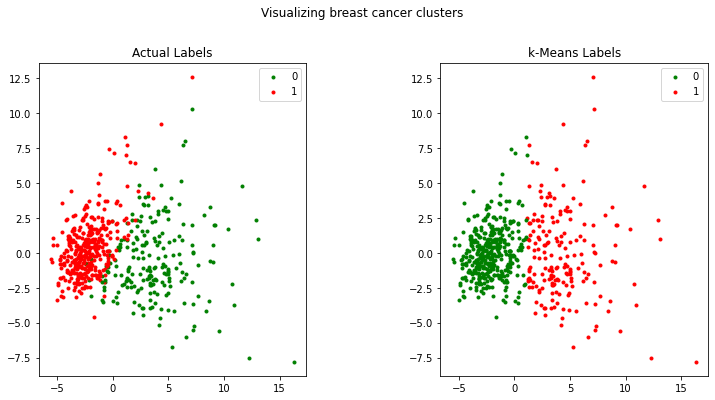

In [5]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Visualizing breast cancer clusters')
fig.subplots_adjust(top=0.85, wspace=0.5)
ax1.set_title('Actual Labels')
ax2.set_title('k-Means Labels')

for i in range(len(y)):
    if y[i] == 0:
        c1 = ax1.scatter(bc_pca[i,0], bc_pca[i,1],c='g', marker='.')
    if y[i] == 1:
        c2 = ax1.scatter(bc_pca[i,0], bc_pca[i,1],c='r', marker='.')
        
    if labels[i] == 0:
        c3 = ax2.scatter(bc_pca[i,0], bc_pca[i,1],c='g', marker='.')
    if labels[i] == 1:
        c4 = ax2.scatter(bc_pca[i,0], bc_pca[i,1],c='r', marker='.')

l1 = ax1.legend([c1, c2], ['0', '1'])
l2 = ax2.legend([c3, c4], ['0', '1'])

# Classification with logistic regression

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

(398, 30) (171, 30)


In [7]:
from sklearn import linear_model

logistic = linear_model.LogisticRegression(max_iter=10000)
logistic.fit(X_train,y_train)
y_pred = logistic.predict(X_test)

In [8]:
from sklearn.metrics import confusion_matrix
print("Accuracy:", logistic.score(X_test, y_test))
print("Confusion matrix:")
display(confusion_matrix(y_test, y_pred))

Accuracy: 0.9824561403508771
Confusion matrix:


array([[ 62,   1],
       [  2, 106]])

In [9]:
logistic.coef_

array([[-0.36022215, -0.37065437, -0.31607433, -0.42392253, -0.17034368,
         0.60368634, -0.77189069, -1.10278226,  0.22958232,  0.14278871,
        -1.21021192,  0.16792803, -0.5605131 , -0.88607955, -0.1693011 ,
         0.60870865, -0.10353489, -0.46753381,  0.51643068,  0.70446749,
        -0.8043121 , -1.31427119, -0.52803186, -0.77963845, -0.5200606 ,
         0.0953213 , -0.98070976, -0.81926084, -1.19784114, -0.11189745]])

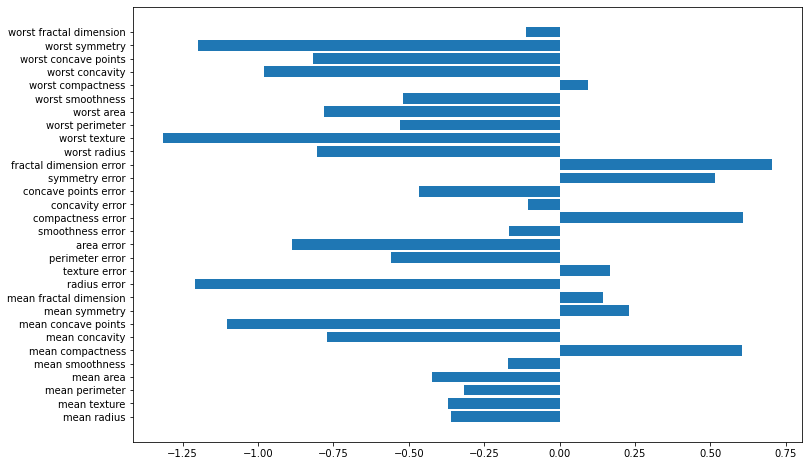

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
plt.barh(list(range(X.shape[1])),logistic.coef_[0], tick_label=X.columns)
plt.show()

# Partial dependence plots

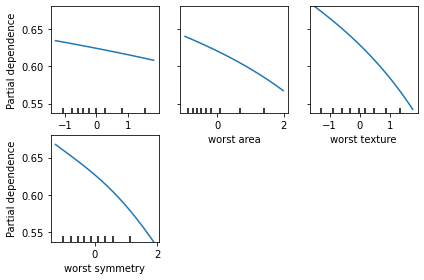

In [11]:
from sklearn.inspection import PartialDependenceDisplay

features_for_pd = ['mean perimeter', 'worst area', 'worst texture', 'worst symmetry']

PartialDependenceDisplay.from_estimator(
    logistic, 
    X, 
    features=features_for_pd)
plt.tight_layout()
plt.show()

# Feature importance via permutation

In [12]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    logistic, X_test, y_test,
    n_repeats=30, random_state=0
)

print("Permutation feature importance:\n")

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
        f"\t{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

Permutation feature importance:

worst texture	0.027 +/- 0.011
mean concave points	0.018 +/- 0.008


# Model interpretation with `shap`

A game-theoretical approach to feature model examination. See the [shap documentation](https://github.com/slundberg/shap).

`conda install -c conda-forge shap`

In [37]:
import shap

# get a resampled distirbution
X100 = shap.utils.sample(X_test, 100)

# explain a single prediction
explainer = shap.Explainer(logistic.predict, X100)
shap_values = explainer(X_test)

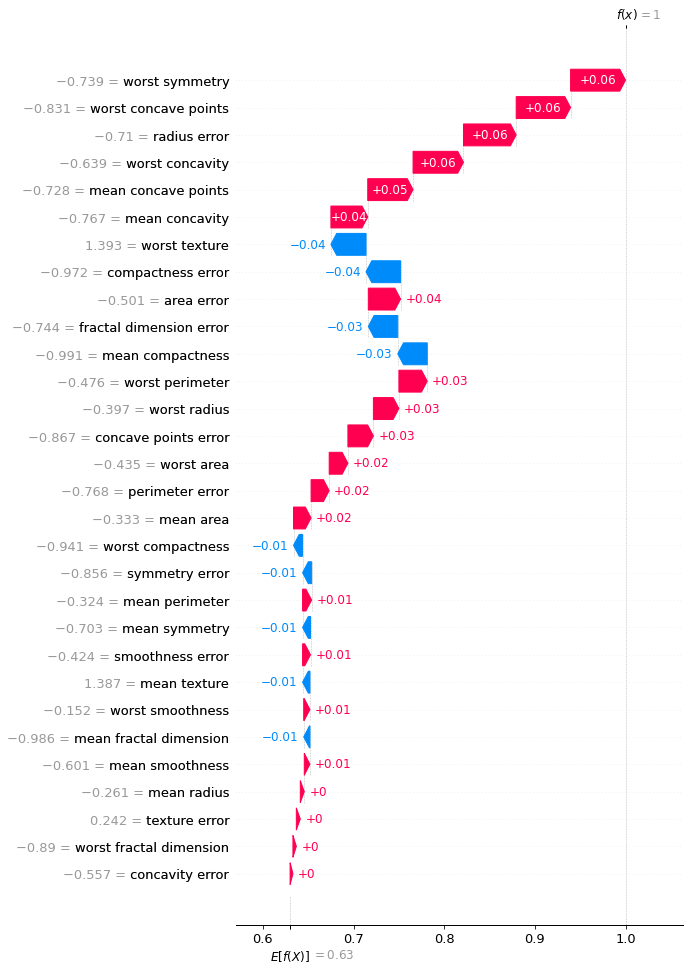

In [38]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
sample_to_explain = 10
shap.plots.waterfall(shap_values[sample_to_explain], max_display=30)

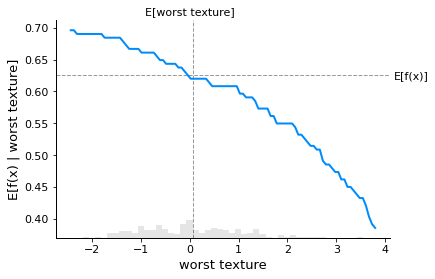

In [15]:
# partial dependence
shap.plots.partial_dependence(
    "worst texture", logistic.predict, X_test, ice=False,
    model_expected_value=True, feature_expected_value=True
)

# Model interpretation with `skater`

Requires the `skater` library. To install from the command line:

```
conda install -c conda-forge skater
```

In [16]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(X_test, feature_names=data.feature_names)
model = InMemoryModel(logistic.predict_proba, examples=X_train, target_names=logistic.classes_)

## Visualize feature importances

[30/30] features ████████████████████ Time elapsed: 0 seconds

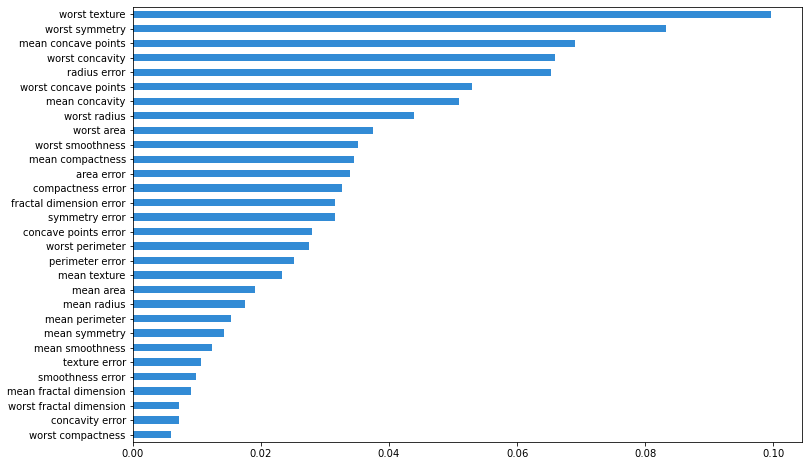

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
plots = interpreter.feature_importance.plot_feature_importance(model, ascending=False, ax=ax)

## Explaining individual predictions

In [24]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
exp = LimeTabularExplainer(
    X_train, 
    feature_names=X.columns,
    discretize_continuous=False, 
    class_names=['0', '1']
)

In [26]:
exp.explain_instance(X_test.iloc[0], logistic.predict_proba).show_in_notebook()

X does not have valid feature names, but LogisticRegression was fitted with feature names


In [29]:
exp.explain_instance(X_test.iloc[1], logistic.predict_proba).show_in_notebook()

X does not have valid feature names, but LogisticRegression was fitted with feature names
